# Renewable Resource Plot

Uncomment the following tow cells (by deleting the leading `#`) if you are running this in Colab.

In [1]:
# !git clone https://github.com/wbarfuss/POLD.git

In [2]:
# cd POLD

In [3]:
# imports
import os
import ast
import glob
import numpy as np
import pandas as pd
import itertools as it
from ast import literal_eval
import matplotlib.pyplot as plt

from utils.valueiteration import get_optimal_average_rewards

In [4]:
# uncomment to compute the raw data

# from compute_ReRe import run
# from utils.partitions import getAllObservations

# datafolder = "./"  # required to read out stored data

# # parameters
# gr = 0.8
# dE = 0.2
# sig = 0.5
# Tmax = 750
# SaSi = 100
# print("--- COPMUTE Renewable Resource ---")
# print("gr  :", gr)
# print("dE  :", dE)
# print("sig :", sig)
# print("Tmax:", Tmax)
# print("SaSi:", SaSi)
# print("----------------------------------")
# print()

# for cap in range(6,10):      
#     allobs = getAllObservations(cap)
#     print()
#     print("C A P A C I T Y ", cap, f" - has {len(allobs)} observations")
#     print()
#     for i, obs in enumerate(reversed(allobs)):
#         print("OBSERVATION Nr", i)
#         run(growthrate=gr, capacity=cap, deltaE=dE, sig=sig, observation=obs,
#             Tmax=Tmax, samplesize=SaSi, datafolder=datafolder)
#         print()



In [5]:
def orderPartition(ObsSig):
    base = max(ObsSig)
    leng = len(ObsSig)
    return sum([(ObsSig[i]-1)*base**(leng-i) for i in range(leng)])

def get_Xdata_from_fn(fn):
    df = pd.read_csv(fn, header=0, index_col=0)
    df['X'] = df['X'].apply(ast.literal_eval)
    return df

def Xdistances(df):
    dists = []
    
    for i, j in it.combinations(range(len(df)), 2):
        dists.append(np.linalg.norm(np.array(df['X'].iloc[i])
                                    - np.array(df['X'].iloc[j])))
    
    return dists

def get_data_from_fn(fn):
    # Capacity
    iC = fn.find("_C") + 2; iCe = fn.find("_r")
    C = int(fn[iC:iCe])
    # growth rate
    ir = fn.find("_r") + 2; ire = fn.find("_dE")
    gr = float(fn[ir:ire])
    # delta effort
    i = fn.find("_dE") + 3; ie = fn.find("_sig")
    dE = float(fn[i:ie])
    # Sigma
    i = fn.find("_sig") + 4; ie = fn.find("_Obs")
    sig = float(fn[i:ie])
    # observation
    iObs = fn.find("_Obs") + 4; iObse = fn.find("_SaSi")
    Obs = ast.literal_eval(fn[iObs:iObse])
    # SampleSize
    i = fn.find("_SaSi") + 5; ie = fn.find("_Tmax")
    SaSi = float(fn[i:ie])
    
    # alpha
    i = fn.find("alpha") + 5; ie = fn.find("_beta")
    alpha = float(fn[i:ie])
    # beta
    i = fn.find("beta") + 4; ie = fn.find("_gamma")
    beta = float(fn[i:ie])
    # gamma
    i = fn.find("gamma") + 5; ie = fn.find(".csv")
    gamma = float(fn[i:ie])    
        
    NrObs = len(Obs)
    
    ObsSig = [len(o) for o in Obs]
    
    fdat = dict(C=C, gr=gr, dE=dE, sig=sig, SaSi=SaSi,
                alpha=alpha, beta=beta, gamma=gamma,
                NrObs=NrObs, ObsSig=ObsSig, Obs=Obs)
    dat = pd.read_csv(fn, header=None, index_col=0).T.iloc[0].to_dict()

    # X distances    
    Xfn = fn[:-4]+"_Xdat.csv"
    ds = Xdistances(get_Xdata_from_fn(Xfn))
    
    data = dict(**fdat, **dat, ds=ds)

    return data

def compile_data(C, r, dE, sig, alpha, beta, gamma, datafolder):
    # looping over all filename with glob
    df = pd.DataFrame()
    
    storage = os.path.expanduser(datafolder)
    for fn in np.sort(glob.glob(storage+f"*C{C}*r{r}*dE{dE}*sig{sig}*SaSi100*"+
                                f"alpha{alpha}*beta{beta}*gamma{gamma}*.csv")):
        if fn.find('Xdat') > -1:  # does file contain 'Xdat'
            continue  # do not consider these file here
        data = get_data_from_fn(fn)
        df = df.append(data, ignore_index=True)
    
    # adjust data types
    floatcols = ['AVG Rew', 'STD Rew', 'AVG LenTraj', 'STD LenTraj',
                 'NrX', 'Rop']
    df[floatcols] = df[floatcols].astype(float)
    df['AllConverged'] = df['AllConverged'].apply(ast.literal_eval)
        
    # normalize reward and length
    C,R,L = df.sort_values("NrObs", ascending=True)\
        [["NrObs","AVG Rew", "AVG LenTraj"]].iloc[-1]
    df["l"] = 1 - df["AVG LenTraj"] / L
    df["r"] = df["AVG Rew"] / R - 1
    
    df["STDr"] = df["STD Rew"] / R
    df["STDl"] = df["STD LenTraj"] / L
        
    # reward * speed outperformance
    df["rl"] = (df["r"] > 0).astype(float) * (df["l"] > 0).astype(float) \
        * df["r"] * df["l"]
    
    # sorting
    df["EquiP"] = df["ObsSig"].apply(np.prod)
    df["OrderP"] = df["ObsSig"].apply(orderPartition)
    
    df["rop"] = df["Rop"] / R - 1
    
    return df

def get_data(C, r, dE, sig, alpha, beta, gamma, datafolder):
    
    fn = f'data/ReRe_C{C}_r{r}_dE{dE}_sig{sig}_alpha{alpha}_beta{beta}' +\
        f'_gamma{gamma}.csv'
        
    print(fn)
    try:
        df = pd.read_csv(fn, index_col=0)
        print("LOADING", fn)
    except:
        df = compile_data(C, r, dE, sig, alpha, beta, gamma, datafolder)
        df.to_csv(fn)
    return df

def get_alldata(Cs=[3,4,5,6,7,8,9,10], r=0.8, dE=0.2, sig=0.25,
                alpha=0.02, beta=250, gamma=0.9, datafolder='./'):
    """
    Compile all data into one - sorted - dataframe
    """
    dat = get_data(Cs[0], r, dE, sig, alpha, beta, gamma, datafolder)
    for C in Cs[1:]:
        # dat = dat.append(get_data(C, r, dE, sig, alpha, beta, gamma,
        #                           datafolder))
        new = get_data(C, r, dE, sig, alpha, beta, gamma, datafolder)
        dat = pd.concat([dat, new])
        
    dat = dat.sort_values(["C", "NrObs", "EquiP", "OrderP"], ascending=True)
    dat = dat.reset_index(drop=True)
    return dat
        
        
data = get_alldata(Cs=[6,7,8,9], sig=0.5)

data/ReRe_C6_r0.8_dE0.2_sig0.5_alpha0.02_beta250_gamma0.9.csv
LOADING data/ReRe_C6_r0.8_dE0.2_sig0.5_alpha0.02_beta250_gamma0.9.csv
data/ReRe_C7_r0.8_dE0.2_sig0.5_alpha0.02_beta250_gamma0.9.csv
LOADING data/ReRe_C7_r0.8_dE0.2_sig0.5_alpha0.02_beta250_gamma0.9.csv
data/ReRe_C8_r0.8_dE0.2_sig0.5_alpha0.02_beta250_gamma0.9.csv
LOADING data/ReRe_C8_r0.8_dE0.2_sig0.5_alpha0.02_beta250_gamma0.9.csv
data/ReRe_C9_r0.8_dE0.2_sig0.5_alpha0.02_beta250_gamma0.9.csv
LOADING data/ReRe_C9_r0.8_dE0.2_sig0.5_alpha0.02_beta250_gamma0.9.csv


In [6]:
def plot_ObsSig(ObsSig, x=0, y=0, w=1, dx=0.02, lw=1.0, ax=None, c='red'):
    if ax==None:
        fig, ax = plt.subplots(1,1)
    C = sum(ObsSig)
    
    # unscaled values
    # dx = 0.02
    # lw = 1.0
    edges = np.cumsum([0] + ObsSig)
    dots = np.array(list(set(range(C)) - set(edges)))
    
    # scaling
    s = lambda ob : w * (ob/C - 0.5) + x
    dots = s(dots)
    edges = s(edges)
    dx = dx*w
    lw = max(0.5, lw*w)
    
    for i in range(len(edges)-1):
        ax.plot([edges[i]+dx, edges[i+1]-dx], [y, y], color=c, lw=lw)
        # ax.plot(dots, y*np.ones(len(dots)), "o", ms=lw/2, color="red")
# plot_ObsSig([5,2,1], x=3, w=1, y=3, c='blue')

In [7]:
Cs = data['C'].unique()
gr = data['gr'].unique()[0]
dE = data['dE'].unique()[0]
sig = data['sig'].unique()[0]
SaSi = data['SaSi'].unique()[0]
print("Cs  :", Cs)
print("gr  :", gr)
print("dE  :", dE)
print("sig :", sig)
print("SaSi:", SaSi)

AvgOptRs = np.array(get_optimal_average_rewards(Cs=Cs, growthrate=gr, dE=dE,
                                                sig=sig))
FullObsRs = [data[(data['C'] == C) & (data['NrObs'] == C)]['AVG Rew'].values
             for C in Cs]
FullObsRs = np.array(FullObsRs).flatten()

avgoptrs = AvgOptRs / FullObsRs - 1

Cs  : [6. 7. 8. 9.]
gr  : 0.8
dE  : 0.2
sig : 0.5
SaSi: 100.0


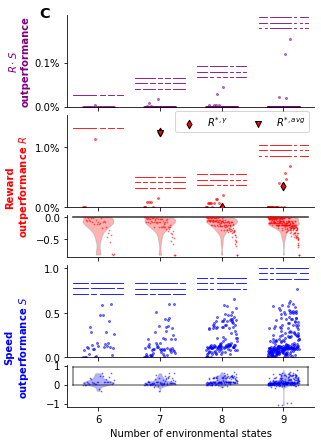

In [8]:
def plot_rl(k="r", c="red", data=data, axes=None, toponly=False):
    
    if axes==None:
        fig, axes = plt.subplots(2-toponly, 1, sharex=True,)
        plt.subplots_adjust(hspace=0.05)
        
    if toponly:
        ax1 = axes
    else:
        ax1, ax2 = axes
        
    Cs = data["C"].unique()
    maxV = data.sort_values([k],ascending=False)[k].iloc[0]
            
    x = data['C'].values
    y = data[k].values

    # random dx
    dx = 0.25*(np.random.rand(len(x))-0.5)  
    
    # observation orderd dx
    w = 0.5
    dx = []
    for C in Cs:
        Nr = sum(data["C"] == C)
        dx += list(np.linspace(w/2, -w/2, Nr))
    
    if not toponly:
        # border
        ax2.plot([min(Cs)-0.4, max(Cs)+0.4], [0,0], 'k-', alpha=0.5)
        ax2.plot([min(Cs)-0.4, max(Cs)+0.4], [1.2*maxV, 1.2*maxV], 'k-',
                 alpha=0.5)
        ax2.plot([min(Cs)-0.4, min(Cs)-0.4], [0, 1.2*maxV], 'k-', alpha=0.5)
        ax2.plot([max(Cs)+0.4, max(Cs)+0.4], [0, 1.2*maxV], 'k-', alpha=0.5)
      
        ax2.plot(x+dx, y, '.', ms=1.5, c=c, alpha=0.5)
        
        dat = [data[data['C'] == C][k].values for C in Cs]
        parts = ax2.violinplot(dat, Cs, showextrema=False)
        for pc in parts['bodies']:
            pc.set_facecolor(c)
            pc.set_edgecolor('gray')
            
        ax2.set_xlim(min(Cs)-0.5, max(Cs)+0.5)
        ax2.spines['right'].set_visible(False)
        ax2.spines['top'].set_visible(False)
        ax2.set_xticks(Cs)
            
    ax1.plot(x+dx, y, '.', ms=4.0, c=c, alpha=0.5)
    
    
    if k == 'r':
        rop = np.unique(data[["C", "rop"]], axis=0)[:,1]
        lrop = ax1.scatter(Cs, rop, marker="d", edgecolors="k", color=c,
                           zorder=100)
        lavg = ax1.scatter(Cs, avgoptrs, marker="v", edgecolors="k", color=c,
                    zorder=109)

        # rop legend
        ax1.legend((lrop, lavg), (r'$R^{*, \gamma}$', r'$R^{*, avg}}$'), ncol=2,
                    loc='upper right', bbox_to_anchor=(1.0, 1.1))        
        
    # Observations
    for C in Cs:
        sortd = data[data['C'] == C].sort_values([k], ascending=False)
        
        j = 0
        for i in range(3)[::-1]:
            v = sortd[k].iloc[i]
            if v > 0.0:
                ObsSig = literal_eval(sortd['ObsSig'].iloc[i])
                plot_ObsSig(ObsSig, x=C,
                            w=0.85, y=sortd[k].iloc[0] + (0.15+j*0.08)*maxV,
                            dx=0.03, lw=1,
                            ax=ax1, c=c)
                j += 1
        
    ax1.set_ylim(0, 1.35*maxV)
    ax1.set_xlim(min(Cs)-0.5, max(Cs)+0.5)
    ax1.set_xticks(Cs)

    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)

    
fsf = 0.55
fig = plt.figure(figsize=(fsf*8, fsf*11))
gs = fig.add_gridspec(8, 1)

ax5 = fig.add_subplot(gs[7, 0])
ax4 = fig.add_subplot(gs[5:7, 0]) #,  yticks=[0, 1.0])

# Rbottom axis
ax3 = fig.add_subplot(gs[4, 0]) #,  yticks=[0, -1.0])

# Rtop axis
ax2 = fig.add_subplot(gs[2:4, 0], yticks=[0, 0.01])
ax2.set_yticklabels([str(t*100)+'%' for t in ax2.get_yticks()])

# RS axis
ax1 = fig.add_subplot(gs[0:2, 0], yticks=[0, 0.001])
ax1.set_yticklabels([str(t*100)+'%' for t in ax1.get_yticks()])

for ax in [ax1, ax2, ax3, ax4]:
    ax.set_xticklabels([])    

plot_rl(k="rl", c="purple", axes=ax1, toponly=True)
plot_rl(k="r", c="red", axes=[ax2, ax3])
plot_rl(k="l", c="blue", axes=[ax4, ax5])


# LABELS
ax5.set_xlabel('Number of environmental states')
ax1.set_ylabel(u'$R \cdot S$\noutperformance', fontdict=dict(color="purple"),
weight='bold')

# ylabel proxies
dax = fig.add_axes([0.5,0.5,0.1,0.1], frameon=False, xticks=[], yticks=[])
dax.annotate(u'Reward\noutperformance $R$', va="center",  ha='center',
             xy=(0.055, 0.58), xycoords='figure fraction', weight='bold',
             rotation=90, color="red")
dax.annotate(u'Speed\noutperformance $S$', va="center", ha='center', 
             xy=(0.055, 0.22), xycoords='figure fraction', weight='bold', 
             rotation=90, color="blue")

ax1.annotate(f"C", xy=(-0.07, 0.94), xycoords="axes fraction", color="k",
              ha="right", va="bottom", fontsize='x-large', weight='bold')

plt.subplots_adjust(top=0.98, right=0.98, bottom=0.08, left=0.2)
plt.savefig("figs/fig_ReRe.png", facecolor='w', dpi=300)

In [18]:
# document this session
import IPython
print(IPython.sys_info())
print()
print('PACKAGES')
!conda list --export | grep -E 'numpy|pandas|matplotlib'

{'commit_hash': '8648ed8d7',
 'commit_source': 'installation',
 'default_encoding': 'utf-8',
 'ipython_path': '/Users/wolf/.miniconda3/envs/RRL/lib/python3.9/site-packages/IPython',
 'ipython_version': '7.22.0',
 'os_name': 'posix',
 'platform': 'macOS-10.16-x86_64-i386-64bit',
 'sys_executable': '/Users/wolf/.miniconda3/envs/RRL/bin/python',
 'sys_platform': 'darwin',
 'sys_version': '3.9.5 (default, May 18 2021, 12:31:01) \n[Clang 10.0.0 ]'}

PACKAGES
matplotlib=3.3.4=py39hecd8cb5_0
matplotlib-base=3.3.4=py39h8b3ea08_0
numpy=1.22.2=pypi_0
numpy-base=1.21.2=py39he0bd621_0
pandas=1.4.1=py39he9d5cce_0
